Begin by importing the libraries needed for data cleaning and preparation.

In [1]:
import numpy as np
import pandas as pd

The next step is to read in the first dataset of interest, ADMISSIONS, and have a first look at the columns and rows. <br> 
This dataset was obtained from the MIMIC III database (https://mimic.physionet.org/).

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv.gz', compression='gzip')
print(admissions.shape)
admissions.head(2)

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1


There are 58976 rows and 19 columns.

#### Columns of interest from the 'admissions' dataset include:
- SUBJECT_ID
- HADM_ID
- ADMITTIME
- HOSPITAL_EXPIRE_FLAG

In [3]:
# exploring the data to determine the datatypes, in particular, of the date columns.
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

Next, convert the dates to datetime format for processing.

In [4]:
#convert ADMITTIME to datetime format. The errors='coerce' argument allows for missing values
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any null dates
print('Number of missing date admissions:', admissions.ADMITTIME.isnull().sum())


Number of missing date admissions: 0


In [5]:
# The next step is to add the target variable 'DEATH' which indicates whether or not a hospitalization resulted in death.
# positive death=1/negative death=0

#admissions['DEATH'] = admissions['DEATHTIME']>pd.Timestamp('00:00:00')
#admissions.DEATH.value_counts()
#print(admissions.DEATH.value_counts())
#print(admissions.DEATH.shape)

In [6]:
# I later realized that the column "HOSPITAL_EXPIRE_FLAG" is same as the "DEATH" column that was created.
# drop DEATH column
#admissions.drop('DEATH', axis=1, inplace=True)
#admissions.columns


In [7]:
admissions.HOSPITAL_EXPIRE_FLAG.value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

5,854 out of 58,976 hospital admissions resulted in death (roughly 10%). Therefore, the dataset will most likely be imbalanced.

The 'admissions' dataframe is ready to go! <br>
<br>
Next: read in the caregiver notes dataset and get an overview of its rows and features.


In [8]:
#Read in the caregiver notes dataset.

notes = pd.read_csv('NOTEEVENTS.csv.gz', compression='gzip')
notes.head(2)

C:\Users\caras\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...


In [9]:
# Viewing categories of caregiver notes to better understand the dataset.
notes.CATEGORY.value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [10]:
notes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
ROW_ID         int64
SUBJECT_ID     int64
HADM_ID        float64
CHARTDATE      object
CHARTTIME      object
STORETIME      object
CATEGORY       object
DESCRIPTION    object
CGID           float64
ISERROR        float64
TEXT           object
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


CHARTDATE records the date at which the note was charted. CHARTDATE will always have a time value of 00:00:00.

CHARTTIME records the date and time at which the note was charted. If both CHARTDATE and CHARTTIME exist, then the date portions will be identical. All records have a CHARTDATE. A subset are missing CHARTTIME. More specifically, notes with a CATEGORY value of ‘Discharge Summary’, ‘ECG’, and ‘Echo’ never have a CHARTTIME, only CHARTDATE. Other categories almost always have both CHARTTIME and CHARTDATE, but there is a small amount of missing data for CHARTTIME (usually less than 0.5% of the total number of notes for that category).

In [11]:
#convert the chart dates and times into datetime format

notes.CHARTTIME = pd.to_datetime(notes.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
notes.CHARTDATE = pd.to_datetime(notes.CHARTDATE, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')


# check to see if there are any null dates
print('Number of missing CHARTTIME:', notes.CHARTTIME.isnull().sum())
print('Number of missing CHARTDATE:', notes.CHARTDATE.isnull().sum())


Number of missing CHARTTIME: 316566
Number of missing CHARTDATE: 0


Since there are so many missing CHARTTIME values, CHARTDATE will be used for processing and analysis (see below). Before analyzing further, the dataframes will be merged.

In [50]:
# Merging the 'admissions' and 'notes' together. A left merge is used so that all rows for hospital admissions are included
# and any caregiver notes that are not associated with a hospital admission are dropped.
df=pd.merge(admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE']],\
            notes[['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CATEGORY','TEXT']], \
            on=('HADM_ID','SUBJECT_ID') , how='left', suffixes=('adm','note'))
print('There are ', len(df), 'rows and ',len(df.columns), 'columns.')


There are  1851959 rows and  8 columns.


In [13]:
list(df.columns)

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'HOSPITAL_EXPIRE_FLAG',
 'ADMISSION_TYPE',
 'CHARTDATE',
 'CATEGORY',
 'TEXT']

Next a new column ENDTIME will be created. This will indicate the date to end note collection for analysis (24 hours after ADMITTIME)


In [14]:
df['ENDTIME'] = df['ADMITTIME'] + pd.DateOffset(1)
df.head(2)

,SUBJECT_ID,HADM_ID,ADMITTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,CHARTDATE,CATEGORY,TEXT,ENDTIME
0,22,165315,2196-04-09 12:26:00,0,EMERGENCY,2196-04-10,Discharge summary,Admission Date: [**2196-4-9**] Discharg...,2196-04-10 12:26:00
1,22,165315,2196-04-09 12:26:00,0,EMERGENCY,2196-04-09,ECG,Normal sinus rhythm. Non-diagnostic repolariza...,2196-04-10 12:26:00


In [15]:
#update dataframe to only include dates within 24 hours of admission

df2 = df[df['CHARTDATE'] <= df['ENDTIME']]

In [25]:
#confirming data types and that there are no null values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444862 entries, 0 to 1851958
Data columns (total 9 columns):
SUBJECT_ID              444862 non-null int64
HADM_ID                 444862 non-null int64
ADMITTIME               444862 non-null datetime64[ns]
HOSPITAL_EXPIRE_FLAG    444862 non-null int64
ADMISSION_TYPE          444862 non-null object
CHARTDATE               444862 non-null datetime64[ns]
CATEGORY                444862 non-null object
TEXT                    444862 non-null object
ENDTIME                 444862 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(3), object(3)
memory usage: 33.9+ MB


In [32]:
#reviewing the merged dataset for multiple SUBJECT_IDs
df2.head(20)

,SUBJECT_ID,HADM_ID,ADMITTIME,HOSPITAL_EXPIRE_FLAG,CHARTDATE,CATEGORY,TEXT,ENDTIME
0,22,165315,2196-04-09 12:26:00,0,2196-04-10,Discharge summary,Admission Date: [**2196-4-9**] Discharg...,2196-04-10 12:26:00
1,22,165315,2196-04-09 12:26:00,0,2196-04-09,ECG,Normal sinus rhythm. Non-diagnostic repolariza...,2196-04-10 12:26:00
2,22,165315,2196-04-09 12:26:00,0,2196-04-09,ECG,Normal sinus rhythm without diagnostic abnorma...,2196-04-10 12:26:00
3,22,165315,2196-04-09 12:26:00,0,2196-04-10,Radiology,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...,2196-04-10 12:26:00
4,22,165315,2196-04-09 12:26:00,0,2196-04-09,Radiology,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...,2196-04-10 12:26:00
5,22,165315,2196-04-09 12:26:00,0,2196-04-09,Radiology,[**2196-4-9**] 10:40 AM\n CHEST (PORTABLE AP) ...,2196-04-10 12:26:00
6,22,165315,2196-04-09 12:26:00,0,2196-04-09,Nursing/other,MICU/SICU NURSING ADMISSION NOTE\n Admitte...,2196-04-10 12:26:00
7,22,165315,2196-04-09 12:26:00,0,2196-04-09,Nursing/other,Resp Care\npt received from eu s/p intubation ...,2196-04-10 12:26:00
8,22,165315,2196-04-09 12:26:00,0,2196-04-10,Nursing/other,S/MICU Nursing Progress Note\nPt extubated at ...,2196-04-10 12:26:00
9,22,165315,2196-04-09 12:26:00,0,2196-04-10,Nursing/other,PT TRANSFER NOTE PLEASE REFER TO ADMIT NOTE [*...,2196-04-10 12:26:00


In [26]:
# Having a look at the quantities of different categories of caregiver notes from the first 24 hours of admission. 
#For now include all categories. This may be somewhere that can be adjusted (i.e., include only notes from specific categories)
# based on the initial results of the machine learning model. one way to do this would be to combine all the text for each subject
# into one text row.
df2.CATEGORY.value_counts()

Radiology            131933
Nursing/other        121682
ECG                   70497
Nursing               56250
Physician             36590
Echo                  14655
Respiratory            5121
Discharge summary      2656
General                2530
Nutrition              1482
Social Work             650
Rehab Services          496
Case Management         265
Consult                  44
Pharmacy                 11
Name: CATEGORY, dtype: int64

The last step before beginning data analysis is to split the data into training and test sets.

In [28]:
# Preparing data further for ML model fitting, separating target variable from features

X = df2.drop(['HOSPITAL_EXPIRE_FLAG'], axis='columns') #feature columns
y = df2.HOSPITAL_EXPIRE_FLAG #target variable

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle=True, random_state=42)


In [30]:
y.value_counts()

0    395268
1     49594
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [45]:
# shuffle dataset in order to randomize all of the samples
df3 = df2.sample(n = len(df2), random_state = 42)
df3 = df3.reset_index(drop = True) #resetting index for the newly shuffled dataset

df_valid_test=df3.sample(frac=0.30,random_state=42) # Save 30% of the data as validation data.
df_test = df_valid_test.sample(frac = 0.5, random_state = 42) #Of the validation data, 50% is set aside for testing 
df_valid = df_valid_test.drop(df_test.index) #dropping the index for the validation data

df_train_all=df3.drop(df_valid_test.index) # remove the rows used for validation; We are left with the rest of the data which will be used for training


In [46]:
df_train_all.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,CHARTDATE,CATEGORY,TEXT,ENDTIME
0,83046,101891,2162-06-20 16:33:00,0,EMERGENCY,2162-06-20,ECG,Sinus rhythm with atrial premature beat. Consi...,2162-06-21 16:33:00
1,138,108120,2131-10-31 08:00:00,0,ELECTIVE,2131-10-31,Nursing/other,ADDM: PT EXTUBATED AT 10:30PM. ABGS GOOD. SATS...,2131-11-01 08:00:00
3,29702,102939,2189-01-25 05:49:00,0,EMERGENCY,2189-01-25,Physician,Chief Complaint: HOTN and bradycardia\n I s...,2189-01-26 05:49:00
4,76653,186308,2164-10-22 17:05:00,0,ELECTIVE,2164-10-23,Nursing,Pt s/p PFO closure. Uneventful OR course. Pt w...,2164-10-23 17:05:00
5,27869,194131,2104-10-28 07:59:00,0,EMERGENCY,2104-10-28,ECG,Atrial paced rhythm\nIntraventricular conducti...,2104-10-29 07:59:00


Now, working with the training data, split the data into 2 categories based on mortality.

In [86]:
# split the training data into positive (death) and negative (no death)
positive = df_train_all.HOSPITAL_EXPIRE_FLAG == 1
df_train_pos = df_train_all.loc[positive]
df_train_neg = df_train_all.loc[~positive]
print('There are ', len(df_train_pos), 'positive samples and ', len(df_train_neg), 'negative samples.')
print('Percent positive samples: ', round(len(df_train_pos)*100/len(df_train_all),2),'%')

There are  34776 positive samples and  276627 negative samples.
Percent positive samples:  11.17 %


There is an imbalance in positive vs negative cases, which would be expected in this dataset. Therefore balancing the data is needed, so that the machine learning model does not always predict negative (no death). Sub-sampling the negative group is one method of doing this.

In [87]:
#sub-sample negatives so there are an equal number of positive and negative samples.
df_train_neg = df_train_neg.sample(n=len(df_train_pos), random_state=42)

# merge the positive and negative samples into the final training set
df_train_final = pd.concat([df_train_pos, df_train_neg],axis = 0)

# shuffle the order of training samples 
df_train_final = df_train_final.sample(n = len(df_train_final), random_state = 42).reset_index(drop = True)

### Step 2: Preprocess text data using Bag of Words model.
#### What is Bag of Words?
<br>
Bag of Words is a method for extracting features from the text for use in machine learning algorithms. Basically, it breaks up a text into individual words, then counts how often each word occurs.


In [109]:
#viewing an example row of the text column
df.TEXT[0]

"Admission Date:  [**2196-4-9**]       Discharge Date:  [**2196-4-10**]\n\nDate of Birth:   [**2131-5-7**]       Sex:  F\n\nService:  ICU\n\nCHIEF COMPLAINT:  Unresponsiveness\n\nHISTORY OF PRESENT ILLNESS:   The patient is a 64-year-old\nfemale with a history of hypertension, depression, prior\nsuicide attempt by overdose, recently with exacerbated mood\ndisorder status post the death of her husband in [**2195-6-2**], now presented after being found unresponsive.  The\npatient's daughters found her in the morning of the day of\npresentation, unresponsive with empty bottles of Ambien and\nZyprexa at the bedside.  Pill count revealed that the patient\nhad likely taken 26 Ambien and 12 Zyprexa.  The patient has\nbeen unable to be alone secondary to depression with suicidal\nideation, and has been living with her daughters.  They note\nthat the patient went to bed at 11 P.M. the night prior to\nadmission and was found at 11 A.M. unresponsive with\nrespiratory depression.  The patient had 

The text above shows that it needs some pre-processing (mainly removing the new line command ('\n'). One way to do this is to create a function to preprocess the text. This way the original data won't be modified.

In [110]:
def preprocess_text(df):
    # This function preprocesses the text by replacing new lines ('\n')  with a space.
    df.TEXT = df.TEXT.str.replace('\n',' ')
    return df
# preprocess the text to deal with known issue
df_train_final = preprocess_text(df_train_final)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [114]:
df_train_final.TEXT[0]

"Neuro: Pt. alert and appropriate after extubation. . Conversing pleasantly with staff.Dozing when left alone. CV: BP labile requiring NEO through the night but weaned to off this morning, HR becoming more tachy to 112, as high as 124 when moving in bed. Pt. takes Toprol XL at home. CVP 8. Resp: extubated at 2100 last evening to nasal prongs. No secretions. BS clear with fine left basilar crackles. C&DB instructed and encouraged. GI: Taking ice chips. No n/v. GU: Adequate huo ~ 30cc/hr. Skin: intact. feet warmer and pulses more easily palpable. Endocrine: insulin drip off @ 0600 with stable BS's 80-90's this morning. Pain: Med. with Mso4 sc through out the night.Pt. stated more relief as of this morning; incisional pain is more right sided chest area. C/o some cramping of upper arms but improved with positioning arms on pillows. Social: Family home for the night ; wife phoned in this morning and pt. condition relayed. Pt. has 8 children (4 boys 4 girls). Plan: Advance activity to OOB t

Now import Python's Natural Language Toolkit (NLTK) and other necessary modules

In [115]:
import nltk
from nltk import word_tokenize
import string # String module provides tools to manipulate strings

Next create a function to separate the text data into tokens (this is called tokenization). Tokens created here will be used to make a vocabulary (set of unique tokens) to be used as a feature for the model. All tokens or top K tokens can be used 

In [105]:
def text_tokenizer(text): # create a function that will tokenize the text, and also remove punctuation and numbers
    
    punc_list = string.punctuation #create list of punctuation marks
    number_list=string.digits #create list of numbers
    num_punc_list = number_list + punc_list #combine the lists together
    t = str.maketrans(dict.fromkeys(num_punc_list, " ")) # replace punctuation and numbers with spaces
    text = text.lower().translate(t) #lowercase all words
    tokens = word_tokenize(text) #tokenize the text 
    return tokens

In [108]:
sample_text = ' "The goal is to turn data into information and information into insight." - Carly Fiorina, former chief executive officer, Hewlett Packard.'
text_tokenizer(sample_text)

['the',
 'goal',
 'is',
 'to',
 'turn',
 'data',
 'into',
 'information',
 'and',
 'information',
 'into',
 'insight',
 'carly',
 'fiorina',
 'former',
 'chief',
 'executive',
 'officer',
 'hewlett',
 'packard']

Now that tokens have been created from the text, CountVectorizer can turn these tokens into features to be used in the machine learning model.

In [118]:
import nltk
nltk.download('punkt')
# fit our vectorizer. This will take a while depending on your computer. 
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = text_tokenizer)
# this could take a while
vect.fit(df_train_final.TEXT.values)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function text_tokenizer at 0x0000028E2F3EF828>,
                vocabulary=None)

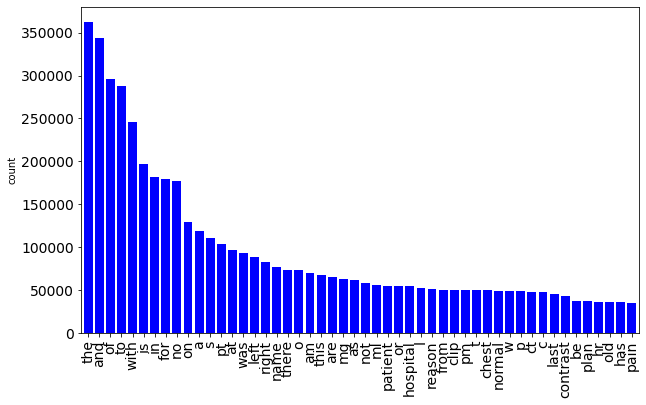

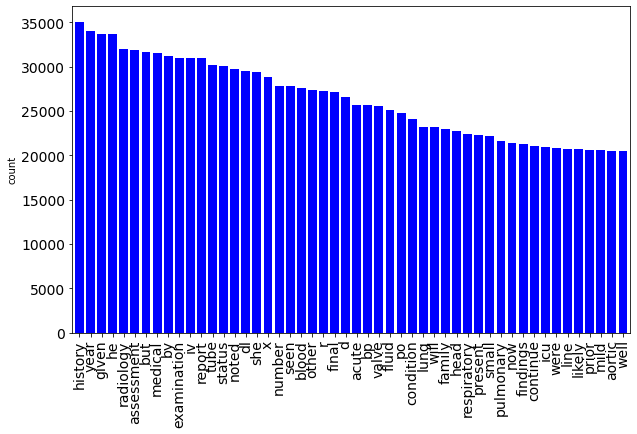

In [121]:
import matplotlib.pyplot as plt

neg_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 0].TEXT)
pos_doc_matrix = vect.transform(df_train_final[df_train_final.HOSPITAL_EXPIRE_FLAG == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [137]:
with np.printoptions(threshold=np.inf):
    print(neg_doc_matrix)

  (0, 33)	1
  (0, 43)	1
  (0, 55)	2
  (0, 62)	1
  (0, 83)	1
  (0, 91)	1
  (0, 115)	4
  (0, 161)	1
  (0, 169)	1
  (0, 173)	2
  (0, 185)	3
  (0, 205)	2
  (0, 230)	1
  (0, 260)	1
  (0, 271)	1
  (0, 272)	2
  (0, 282)	1
  (0, 330)	1
  (0, 358)	2
  (0, 362)	2
  (0, 365)	2
  (0, 415)	1
  (0, 431)	1
  (0, 443)	1
  (0, 446)	1
  :	:
  (34775, 1462)	2
  (34775, 1470)	1
  (34775, 1710)	1
  (34775, 1779)	1
  (34775, 1786)	1
  (34775, 1826)	1
  (34775, 1852)	1
  (34775, 1923)	2
  (34775, 2027)	2
  (34775, 2069)	1
  (34775, 2083)	1
  (34775, 2089)	1
  (34775, 2101)	2
  (34775, 2108)	1
  (34775, 2152)	1
  (34775, 2164)	2
  (34775, 2304)	1
  (34775, 2445)	1
  (34775, 2447)	1
  (34775, 2506)	1
  (34775, 2576)	1
  (34775, 2621)	1
  (34775, 2751)	1
  (34775, 2876)	2
  (34775, 2921)	3


In [138]:
stopwords = ['the','and','to','with','is','in','for','on','a', 's', 'pt', 'at', 'was', 'left', 'right', 'name', 'there', 'o', 'p', 'am', 'as', 'patient', 'or', 'from', 'c', 'p', 'be','has']

Add the list of stop words as an argument for CountVectorizer

In [140]:

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = text_tokenizer, 
                       stop_words = stopwords)
# this could take a while
vect.fit(df_train_final.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['the', 'and', 'to', 'with', 'is', 'in', 'for', 'on',
                            'a', 's', 'pt', 'at', 'was', 'left', 'right',
                            'name', 'there', 'o', 'p', 'am', 'as', 'patient',
                            'or', 'from', 'c', 'p', 'be', 'has'],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function text_tokenizer at 0x0000028E2F3EF828>,
                vocabulary=None)

Transform the text into vectors

In [141]:
X_train_tf = vect.transform(df_train_final.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

Get labels

In [142]:
y_train = df_train_final.HOSPITAL_EXPIRE_FLAG
y_valid = df_valid.HOSPITAL_EXPIRE_FLAG

In [ ]:
Step 3: Build a simple predictive model

In [143]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

C:\Users\caras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [144]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [145]:
print(y_train[:10].values)
print(y_train_preds[:10])

[0 0 1 1 1 0 0 1 1 1]
[0.28896677 0.46793583 0.51763337 0.45659658 0.80529983 0.42538565
 0.78462137 0.45945234 0.50693792 0.55169123]


In [146]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

Train AUC:0.768
Valid AUC:0.757
Train accuracy:0.697
Valid accuracy:0.671
Train recall:0.724
Valid recall:0.712
Train precision:0.687
Valid precision:0.212
Train specificity:0.670
Valid specificity:0.665
Train prevalence:0.500
Valid prevalence:0.112


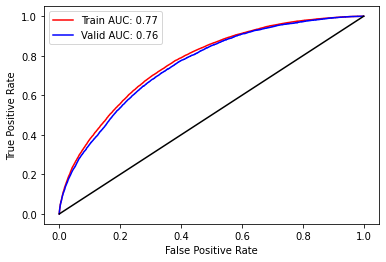

In [147]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

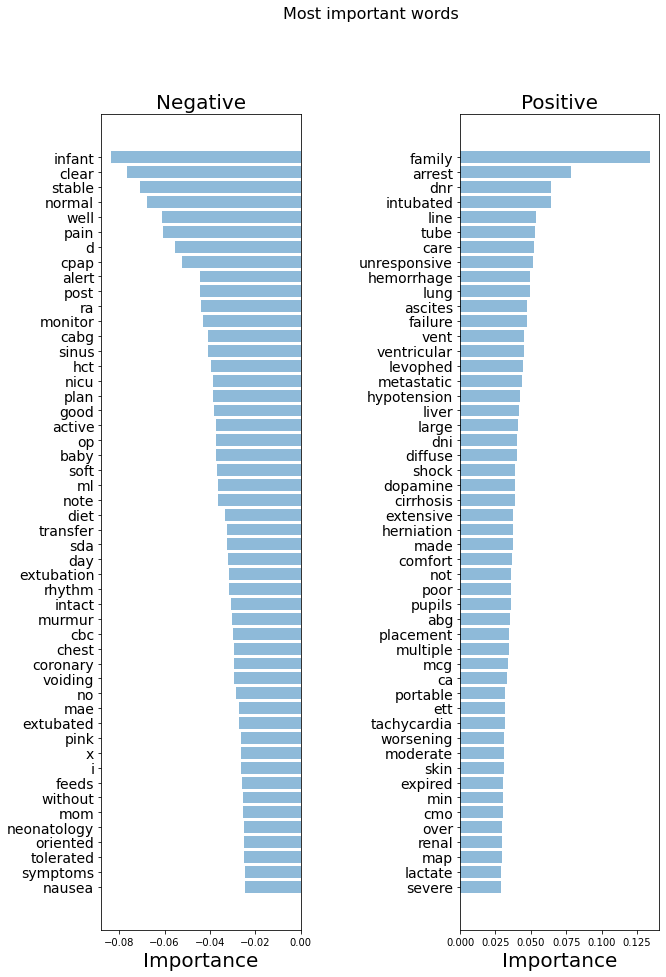

In [148]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(vect, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")